## Experiment 2: order sensitivity

In [1]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import SGD
#from tqdm.auto import tqdm
from gp import *
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Using device: cpu


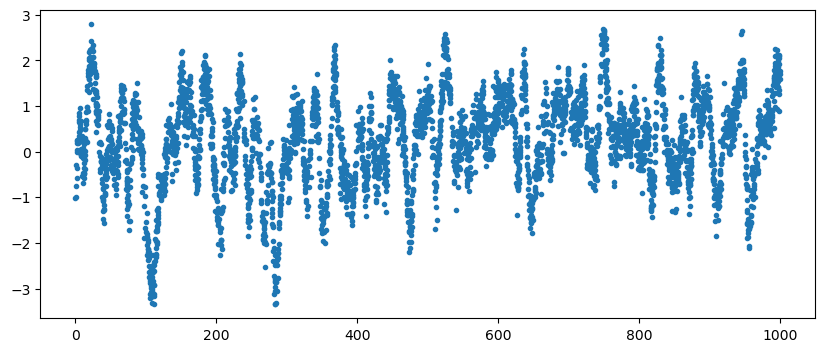

In [2]:
#data
N_total = 4000
X = 1000*torch.rand(N_total,1, device = device)
hypers = [1, 5, 0.1]
gp_true = GP(hypers = hypers)
y = gp_true.sample_from_prior(X)
X_data = X.detach()
y_data = y.detach()

plt.figure(figsize=(10,4))
plt.plot(X_data.cpu(),y_data.cpu(),'.')
    

In [3]:
#setting up
# variables to extract
list_nsamples = [500, 1000, 1500, 2000, 3000, 4000]
list_M = [50, 100, 150]


In [4]:
out_nll = []
times_nll = []
out_elbo = []
times_elbo = []


In [5]:
out_proj = []
times_proj = []

#training setting
n_steps = 2001
lr = 0.01
tol = 1e-3
optimizer = 'Adam'

In [6]:
#training
print('starting training ....')
idx_total = torch.randperm(N_total)
for n_samples in list_nsamples:
    print(f'---observations = {n_samples}')
    # choose n unique indices at random
    idx = idx_total[:n_samples]
    # subset of the data
    X_train = X_data[idx]
    y_train = y_data[idx]
    
    
    ##### Vanilla GP (NLL) #####
    # Vanilla GP (NLL)
    gp_nll = GP(X_train, y_train, kernel = 'SE')
    out = gp_nll.train_step(obj = 'nll', opt_name=optimizer, lr=lr, n_steps=n_steps, tol=tol, verbose = True)

    times_nll.append(out["time"])     # save elapsed time
    out_nll.append(out["nll"])
    
    for M in list_M:
        Meq = M
        if M > 0.5*n_samples:
            times_elbo.append(0)
            out_elbo.append(0)
            times_proj.append(0)     # save elapsed time
            out_proj.append(0)
            break
        print(f'------M = {Meq}')
        
    
        ##### SparseGP (ELBO) ##### 
        # SparseGP (ELBO)
        gp_elbo = GP(X_train, y_train, kernel = 'SE', M=Meq, method = 'VFE')
        out = gp_elbo.train_step(obj = 'elbo', opt_name=optimizer, lr=lr, n_steps=n_steps, tol=tol, verbose = True)        

        times_elbo.append(out["time"])     # save elapsed time
        out_elbo.append(out["nll"])

        ##### ProjGP ##### 
        gp_proj = GP(X_train, y_train, kernel = 'SE', M=Meq, method = 'proj-repulsive')
        out = gp_proj.train_step(obj = 'proj', opt_name=optimizer, lr=lr, n_steps=n_steps, tol=tol, verbose = True)        

        times_proj.append(out["time"])     # save elapsed time
        out_proj.append(out["nll"])
        
print('Training complete')        
    

starting training ....
---observations = 500
Using device: cpu
Optimising nll using Adam
Epoch 0: loss = 662.2732
Epoch 200: loss = 382.1116
Early stop at iteration 356: loss did not improve for 5 steps.
Elapsed time: 4.9[s] with NLL = 373.85
------M = 50
Using device: cpu
[init_Z_kmeanspp] KMeans finished in 0.115 seconds
Optimising elbo using Adam
Epoch 0: loss = 1029.4495
Epoch 200: loss = 654.3234
Epoch 400: loss = 613.1885
Epoch 600: loss = 604.4013
Epoch 800: loss = 601.1078
Epoch 1000: loss = 600.1228
Epoch 1200: loss = 599.6893
Epoch 1400: loss = 598.6353
Epoch 1600: loss = 597.3022
Epoch 1800: loss = 596.9496
Epoch 2000: loss = 596.6949
Elapsed time: 8.1[s] with NLL = 528.20
Using device: cpu
Repulsion running time: 0.8586 seconds
Optimising proj using Adam
Epoch 0: loss = 76.8144
Epoch 200: loss = 69.0491
Epoch 400: loss = 68.2231
Early stop at iteration 505: loss did not improve for 5 steps.
Elapsed time: 2.7[s] with NLL = 561.27
------M = 100
Using device: cpu
[init_Z_kmean

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
Epoch 1600: loss = 403.8866
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Fa

[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

Epoch 200: loss = 1227.3991
Epoch 400: loss = 1122.4364
Epoch 600: loss = 1087.7234
Epoch 800: loss = 1074.5825
Epoch 1000: loss = 1070.0073
Epoch 1200: loss = 1067.4635
Epoch 1400: loss = 1064.5313
Epoch 1600: loss = 1051.3699
Epoch 1800: loss = 1032.7906
Epoch 2000: loss = 1027.4041
Elapsed time: 10.3[s] with NLL = 854.06
Using device: cpu
Repulsion running time: 1.0962 seconds
Optimising proj using Adam
Epoch 0: loss = 76.8372
Epoch 200: loss = 63.1126
Early stop at iteration 223: loss did not improve for 5 steps.
Elapsed time: 3.6[s] with NLL = 1080.94
------M = 100
Using device: cpu
[init_Z_kmeanspp] KMeans finished in 0.173 seconds
Optimising elbo using Adam
Epoch 0: loss = 1905.5049
Epoch 200: loss = 939.6955
Epoch 400: loss = 809.7759
Epoch 600: loss = 785.7998
Epoch 800: loss = 769.1187
Epoch 1000: loss = 759.6642
Epoch 1200: loss = 754.2459
Epoch 1400: loss = 752.2515
Epoch 1600: loss = 751.4231
Epoch 1800: loss = 751.3068
Epoch 2000: loss = 751.1304
Elapsed time: 14.3[s] wit

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-02
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

Repulsion running time: 1.1103 seconds
Optimising proj using Adam
Epoch 0: loss = 217.0342
Epoch 200: loss = 170.0278
Early stop at iteration 358: loss did not improve for 5 steps.
Elapsed time: 6.7[s] with NLL = 547.60
---observations = 1500
Using device: cpu
Optimising nll using Adam
Epoch 0: loss = 1746.4491
Epoch 200: loss = 764.7115
Early stop at iteration 383: loss did not improve for 5 steps.
Elapsed time: 48.5[s] with NLL = 723.97
------M = 50
Using device: cpu
[init_Z_kmeanspp] KMeans finished in 0.118 seconds
Optimising elbo using Adam
Epoch 0: loss = 3075.1424
Epoch 200: loss = 1843.1547
Epoch 400: loss = 1678.5440
Epoch 600: loss = 1577.0257
Epoch 800: loss = 1514.4693
Epoch 1000: loss = 1503.3847
Epoch 1200: loss = 1501.8323
Epoch 1400: loss = 1501.5431
Epoch 1600: loss = 1501.4676
Epoch 1800: loss = 1501.4088
Epoch 2000: loss = 1501.3727
Elapsed time: 10.6[s] with NLL = 1203.97
Using device: cpu
Repulsion running time: 1.7643 seconds
Optimising proj using Adam
Epoch 0: lo

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

Epoch 1600: loss = 792.6237
Epoch 1800: loss = 789.0971
Epoch 2000: loss = 789.1131
Elapsed time: 32.6[s] with NLL = 760.22
Using device: cpu
Repulsion running time: 1.9416 seconds
Optimising proj using Adam
Epoch 0: loss = 213.2704
Epoch 200: loss = 166.2433
Early stop at iteration 353: loss did not improve for 5 steps.
Elapsed time: 13.2[s] with NLL = 737.97
---observations = 2000
Using device: cpu
Optimising nll using Adam
Epoch 0: loss = 2239.8535
Epoch 200: loss = 929.3051
Early stop at iteration 388: loss did not improve for 5 steps.
Elapsed time: 101.2[s] with NLL = 867.80
------M = 50
Using device: cpu
[init_Z_kmeanspp] KMeans finished in 0.150 seconds
Optimising elbo using Adam
Epoch 0: loss = 4069.2087
Epoch 200: loss = 2372.5758
Epoch 400: loss = 2120.5866
Epoch 600: loss = 2005.1692
Epoch 800: loss = 1950.4280
Epoch 1000: loss = 1939.1903
Epoch 1200: loss = 1937.3066
Epoch 1400: loss = 1936.5611
Epoch 1600: loss = 1936.2350
Epoch 1800: loss = 1936.1706
Epoch 2000: loss = 19

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

Repulsion running time: 2.3441 seconds
Optimising proj using Adam
Epoch 0: loss = 218.4942
Epoch 200: loss = 175.1284
Epoch 400: loss = 173.0973
Early stop at iteration 430: loss did not improve for 5 steps.
Elapsed time: 24.8[s] with NLL = 901.77
---observations = 3000
Using device: cpu
Optimising nll using Adam
Epoch 0: loss = 3178.9119
Epoch 200: loss = 1244.8740
Epoch 400: loss = 1138.5552
Early stop at iteration 414: loss did not improve for 5 steps.
Elapsed time: 295.4[s] with NLL = 1138.55
------M = 50
Using device: cpu
[init_Z_kmeanspp] KMeans finished in 0.159 seconds
Optimising elbo using Adam
Epoch 0: loss = 6084.3047
Epoch 200: loss = 3476.6057
Epoch 400: loss = 3037.6635
Epoch 600: loss = 2858.8811
Epoch 800: loss = 2763.1646
Epoch 1000: loss = 2732.1995
Epoch 1200: loss = 2726.2158
Epoch 1400: loss = 2724.5530
Epoch 1600: loss = 2723.8222
Epoch 1800: loss = 2723.4120
Epoch 2000: loss = 2722.9361
Elapsed time: 14.2[s] with NLL = 2036.39
Using device: cpu
Repulsion running 

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1

[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1.0e-03
[safe_cholesky] Failed, retrying with jitter=1.0e-05
[safe_cholesky] Failed, retrying with jitter=1.0e-04
[safe_cholesky] Failed, retrying with jitter=1

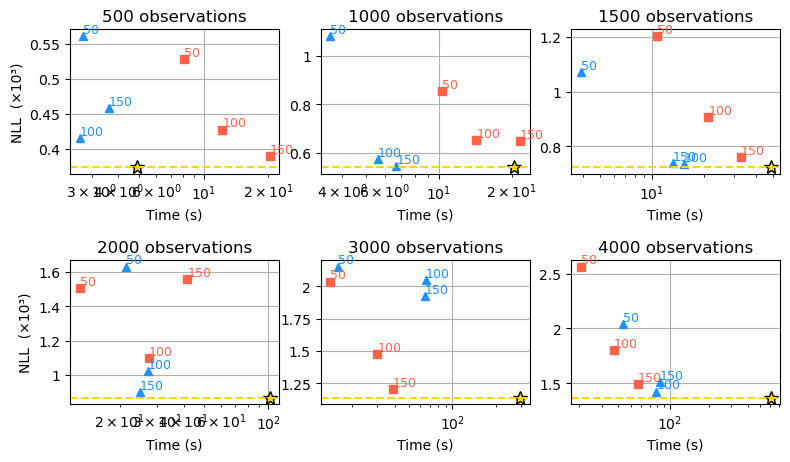

In [7]:
##### plot the results 
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda x, pos: f'{x/1000:.4g}')

#!out_elbo = out_proj
#!times_elbo = times_proj
N = len(list_nsamples)
M = len(list_M)

fig, axs = plt.subplots(2, math.ceil(N/2), figsize=(8, 5), sharey=False)  # 2 rows
axs = axs.flatten()

for i in range(N):
    ax = axs[i]
    
    # plot time vs output for each method
    ax.semilogx(times_nll[i], out_nll[i], '*-', c='gold', markersize=10, 
    markeredgecolor='k',   # black border
    markeredgewidth=1,   # thickness of the border
    label='NLL')
    for j in range(M):  
    
        ax.semilogx(times_elbo[M*i + j], out_elbo[M*i + j], 's-', c='tomato', label='ELBO')
        ax.text(times_elbo[M*i + j], out_elbo[M*i + j], list_M[j], c='tomato', fontsize=9, ha='left', va='bottom')
        ax.semilogx(times_proj[M*i + j], out_proj[M*i + j],'^-', c='dodgerblue' , label='Proj')
        ax.text(times_proj[M*i + j], out_proj[M*i + j], list_M[j], c='dodgerblue', fontsize=9, ha='left', va='bottom')
    
    ax.axhline(y=out_nll[i], color='gold', linestyle='--', label='grund truth')  # constant y
    ax.yaxis.set_major_formatter(formatter)


    
    
    ax.set_title(f'{list_nsamples[i]} observations')
    ax.set_xlabel('Time (s)')
    if i % math.ceil(N/2) == 0:   # only first col gets y-label
        ax.set_ylabel('NLL  (×10³)')
    #ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.6, bottom=0.18)  

#plt.savefig("img/exp1.pdf", bbox_inches='tight', pad_inches=0)


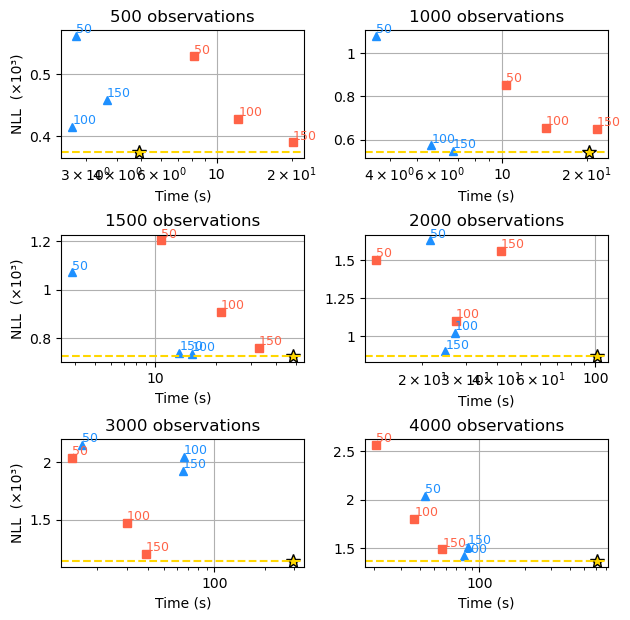

In [23]:
from matplotlib.ticker import FuncFormatter

def decimal_formatter(x, pos):
    # Format numbers in plain decimals without scientific notation
    if x >= 1:
        return f"{x:.0f}"       # no decimals for large numbers
    else:
        return f"{x:.3f}"       # 3 decimals for small numbers

fig, axs = plt.subplots(3, 2, figsize=(6.5,6.5), sharey=False)  # 3 rows, 2 cols
axs = axs.flatten()

for i in range(N):
    ax = axs[i]

    # plot time vs output for each method
    ax.semilogx(times_nll[i], out_nll[i], '*-', c='gold', markersize=10,
                markeredgecolor='k', markeredgewidth=1, label='NLL')
    for j in range(M):  
        ax.semilogx(times_elbo[M*i + j], out_elbo[M*i + j], 's-', c='tomato', label='ELBO')
        ax.text(times_elbo[M*i + j], out_elbo[M*i + j], list_M[j], c='tomato', fontsize=9, ha='left', va='bottom')
        ax.semilogx(times_proj[M*i + j], out_proj[M*i + j], '^-', c='dodgerblue', label='Proj')
        ax.text(times_proj[M*i + j], out_proj[M*i + j], list_M[j], c='dodgerblue', fontsize=9, ha='left', va='bottom')

    ax.axhline(y=out_nll[i], color='gold', linestyle='--', label='ground truth')
    ax.yaxis.set_major_formatter(formatter)

    # ✅ Force all x-ticks to be plain decimals
    ax.xaxis.set_major_formatter(FuncFormatter(decimal_formatter))

    # ✅ Keep labels horizontal (no slant)
    ax.tick_params(axis='x', rotation=0)

    ax.set_title(f'{list_nsamples[i]} observations')
    ax.set_xlabel('Time (s)')
    if i % 2 == 0:   # first column only
        ax.set_ylabel('NLL  (×10³)')

    ax.grid(True)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.6, bottom=0.12)

plt.savefig("img/exp1.pdf", bbox_inches='tight', pad_inches=0)
